# Atelier - Détecter et simuler des changements du territoire par apprentissage profond

**L'objectif** de cet atelier est d'aborder la *détection de changements*. En effet, cette thématique est cruciale en géomatique : il s'agit d'identifier les éléments au sol ayant changé de nature (ou d'usage). Cette étape est le point clé de la mise à jour des bases de données cartographiques. Elle est cependant fastidieuse et coûteuse à réaliser manuellement par photo-interprétation, car les changements sont très localisés. Par ailleurs, tous les changements ne se valent pas : la végétation subit des changements saisonniers qui ne sont pas pertinents à modéliser.

Nous allons voir ici comment l'apprentissage profond peut servir de levier pour accélérer la détection de changements du territoire.

In [ ]:
!pip install torchgeo

In [34]:
# Import des bibliothèques utiles
import matplotlib.pyplot as plt
import numpy as np

# Bibliothèques spécifiques apprentissage profond et données géospatiales
import sklearn
import torch
import torchgeo.datasets

# Fonctions de traitement d'image
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import equalize
from torchvision.transforms.functional import resize

# Éléments interactifs
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

## Un jeu de données de détection de changements

Le jeu de données [OSCD](https://rcdaudt.github.io/oscd/) (*Onera Satellite Change Detection dataset*) contient 24 paires d'images satellitaires, produites par la constellation Sentinel-2. Chaque paire contient deux images, prises à 3 ans d'intervalle, couvrant la même zone géographique. Une carte de changements indiquant les pixels pour lesquels la couverture du sol a changé entre les deux dates est également fournie.

Examinons ce jeu de données. Il est embarqué nativement dans la bibliothèque [torchgeo](https://torchgeo.readthedocs.io/en/stable/), dédié à l'apprentissage profond sur des données géospatiales.

In [3]:
oscd_dataset = torchgeo.datasets.OSCD(root="data/", split="train", bands=("B04", "B03", "B02"), download=True)

In [4]:
idx = 0
image_before = oscd_dataset[idx]['image1']
image_after = oscd_dataset[idx]['image2']
mask = oscd_dataset[idx]['mask']

print(image_before.shape)
print(image_before)

torch.Size([3, 339, 563])
tensor([[[1323., 1192., 1086.,  ...,  501.,  501.,  938.],
         [1395., 1395., 1210.,  ...,  505., 1031., 1031.],
         [1371., 1371., 1250.,  ...,  456., 1006., 1006.],
         ...,
         [ 851.,  664.,  655.,  ...,  784.,  804.,  791.],
         [ 836.,  967.,  483.,  ...,  800.,  798.,  776.],
         [ 710.,  939.,  629.,  ...,  768.,  815.,  805.]],

        [[1348., 1214., 1126.,  ...,  718.,  718., 1037.],
         [1439., 1439., 1234.,  ...,  743., 1059., 1059.],
         [1288., 1288., 1262.,  ...,  705., 1061., 1061.],
         ...,
         [ 995.,  877.,  880.,  ...,  939.,  948.,  943.],
         [ 994., 1064.,  707.,  ...,  930.,  933.,  933.],
         [ 978., 1007.,  831.,  ...,  908.,  933.,  962.]],

        [[1483., 1352., 1260.,  ...,  872.,  872., 1143.],
         [1490., 1490., 1366.,  ...,  892., 1162., 1162.],
         [1452., 1452., 1398.,  ...,  830., 1174., 1174.],
         ...,
         [1034.,  939.,  954.,  ...,  989.,

Nous récupérons ici un triplet, constitué :
- d'une image à une date $t_1$ (2015),
- d'une image à une date $t_2$ (2018),
- un masque binaire indiquant les pixels ayant changé.

Les valeurs des pixels des images indiquent la réflectance au sol. Par convention, celle-ci est donnée en une valeur entière entre 0 et 10000. Pour visualiser les images, nous allons les convertir en réels entre 0 et 1, puis appliquer une [égalisation d'histogramme](https://fr.wikipedia.org/wiki/%C3%89galisation_d%27histogramme).

In [5]:
def min_max_normalization(tensor):
    # Convert a tensor to [0,1] using min-max normalization
    min = torch.min(tensor)
    max = torch.max(tensor)
    return (tensor - min) / (max - min)

def s2_tensor_to_image(tensor):
    # Apply min max normalization, convert to PIL and apply histogram equalization
    return equalize(to_pil_image(min_max_normalization(tensor)))

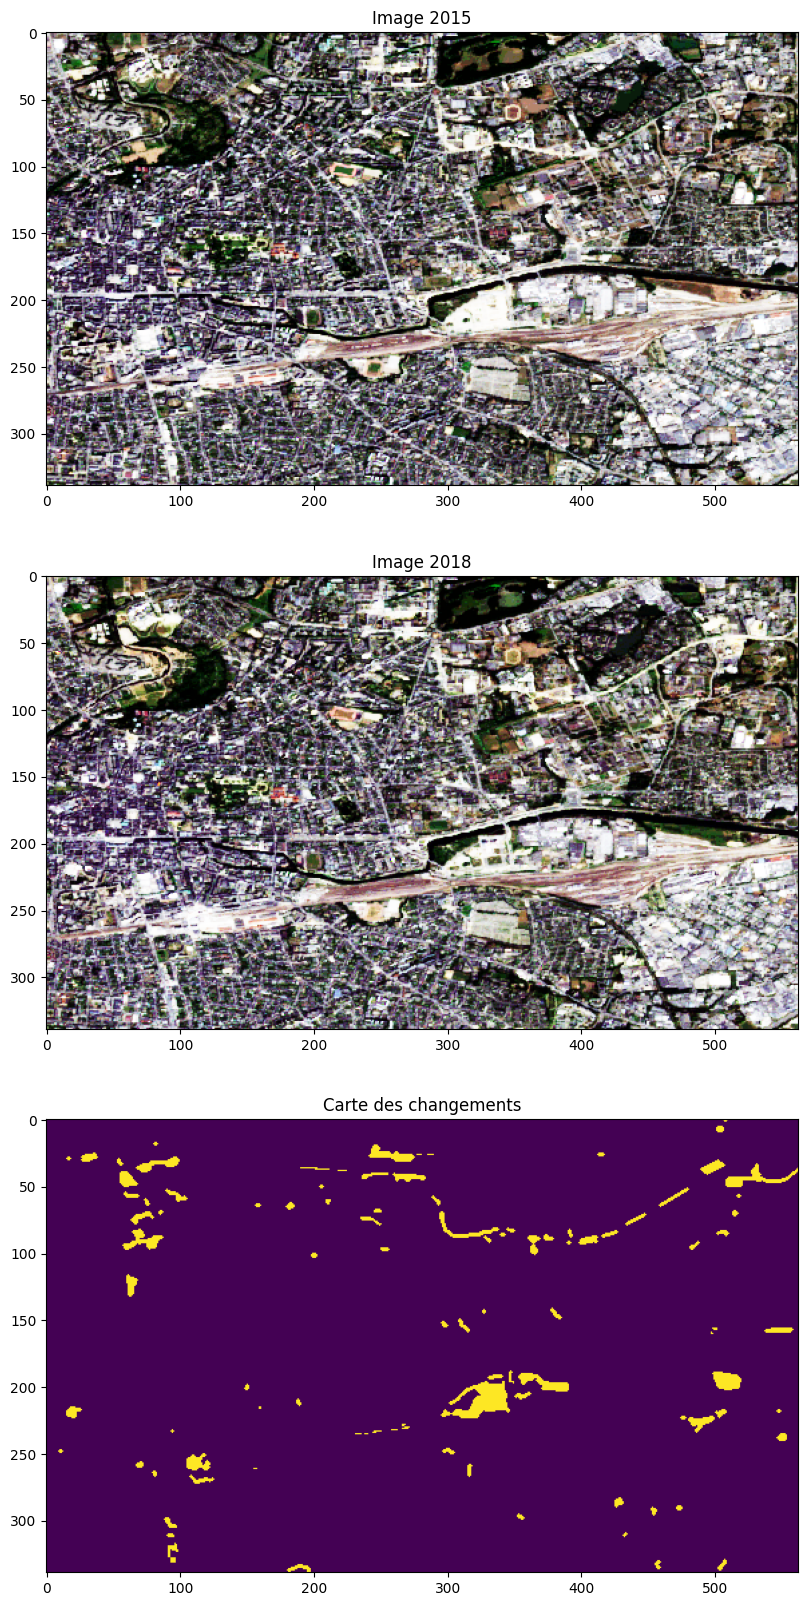

In [6]:
fig = plt.figure(figsize=(10, 20))
fig.add_subplot(311)
plt.imshow(s2_tensor_to_image(image_before))
plt.title("Image 2015")
fig.add_subplot(312)
plt.imshow(s2_tensor_to_image(image_after))
plt.title("Image 2018")
fig.add_subplot(313)
plt.imshow(mask)
plt.title("Carte des changements")
plt.show()

## Détection de changements

Comment identifier les changements pertinents qui ont eu lieu entre l'image de 2015 et l'image de 2018 ? L'approche classique en photo-interprétation consiste à examiner chaque région des deux images et de les comparer entre elles. Intuitivement, une solution pour automatiser cette comparaison serait de calculer des différences entre pixels. Chaque pixel de position $[i,j]$ est décrit par un vecteur contenant ici trois valeurs : $r$ la réflectance dans le canal rouge, $g$ la réflectance dans le vert, $b$ la réflectance dans le bleu.

On peut donc calculer une matrice qui donne pour chaque position la distance euclidienne entre le pixel 2015 et le pixel 2018 :

$$ M = (\lVert (r,g,b)_{2015} - (r,g,b)_{2018} \rVert)_{i,j}$$

In [7]:
pixel_distance = torch.linalg.norm(image_before - image_after, dim=0)

Pour indiquer quel pixel a changé, il suffit ensuite de comparer cette distance à un seuil. Si la distance est au-dessus du seuil choisi, on considère que le pixel a changé significativement. Sinon, la zone n'a pas bougé. Plus le seuil est élevé, plus les réflectances mesurées doivent avoir évolué pour que le pixel soit considéré comme changé.

In [51]:
@interact(threshold = widgets.IntSlider(500, min=0, max=5000, step=100, description="Seuil"))
def show_change_map(threshold):
    fig = plt.figure(figsize=(15, 10))
    fig.add_subplot(121)
    plt.imshow(pixel_distance > threshold, vmin=0., vmax=1.0)
    plt.title("Changements détectés")
    fig.add_subplot(122)
    plt.imshow(mask)
    plt.title("Vérité terrain")
    plt.show()

    cm = sklearn.metrics.confusion_matrix(pixel_distance.ravel() > threshold, mask.ravel())
    sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=["No change", "Change"]).plot()

interactive(children=(IntSlider(value=500, description='Seuil', max=5000, step=100), Output()), _dom_classes=(…

Il est notamment possible de calculer la matrice de confusion de cette approche. Elle permet de mesurer le nombre de faux positifs (pixels  détectés comme changés alors qu'ils ne le sont pas) et de faux négatifs (pixels changés qui ne sont pas détectés en tant que tel). Cette matrice de confusion dépend bien entendu du seuil choisi.

Pour synthétiser, on préfère en général la [courbe ROC](https://fr.wikipedia.org/wiki/Courbe_ROC), qui trace l'évolution du taux de changements correctement détectés par rapport au taux de faux positifs :

/home/NAudebert/.venvs/dl/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


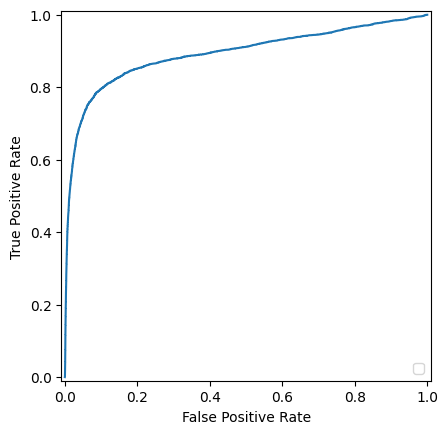

In [53]:
fpr, tpr, _ = sklearn.metrics.roc_curve(mask.ravel().int(), pixel_distance.ravel())
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

N'hésitez pas à expérimenter avec d'autres images en changeant la variable `idx` et à modifier la valeur du seuil.

En pratique, cette heuristique a tendance à produire beaucoup de faux positifs. En effet, il y a de nombreuses raisons pour lesquelles les réflectances peuvent changer :
- variations saisonnières, notamment de la végétation,
- rénovations/altérations d'un revêtement au sol (réfection d'une route, par exemple),
- événements météorologiques, comme la pluie,
- etc.

Ces événements changent la radiométrie du matériau au sol mais ne modifient pas pour autant sa nature, au sens de l'occupation des sols. Ce ne sont en général pas des changements qui nous intéressent : ce sont des faux positifs. Le problème central est que la distance dans l'espace des pixels ne prend pas en compte le contexte spatial, ni la sémantique des objets. C'est là où les représentations apprises par des réseaux de neurones peuvent nous aider à faire abstraction de ces changements « inintéressants ».

### Encodeurs sur étagères

L'intérêt des réseaux de neurones est leur capacité à apprendre des représentations vectorielles des données d'entrée, qui encodent (au moins en partie) la sémantique de ces données. Par exemple, pour les images satellitaires, il existe des réseaux de neurones ayant été entraînés sur de grandes bases de données d'images, avec une large couverture géographique et temporelle. Ces modèles sont entraînés pour encoder une image en un vecteur, qui ne contient que l'information « utile ».

Nous allons pouvoir exploiter ces représentations apprises pour réaliser la même opération que ci-dessus, mais dans l'espace de représentation d'un tel réseau de neurones, plutôt que l'espace des pixels. Voyons plus en détails cette approche.

Pour commencer, nous pouvons charger à l'aide de `torchgeo` un modèle pré-entraîné. Il s'agit de l'architecture ResNet-50, entraîné sur un grand nombre d'images satellitaires Sentinel-2 à l'aide de la méthode [SeCo](https://arxiv.org/abs/2103.16607). *SeCo* (*Seasonal Contrast*) est une technique d'apprentissage non-supervisée conçue pour encoder des images satellitaires en une représentation qui est invariante aux variations saisonnières. Ces représentations sont ainsi particulièrement adaptées à la détection de changements, puisque deux images similaires qui représentent la même région seront encodées par le même vecteur à l'aide de cette méthode, même si la végétation a changé, par exemple. Pour que la représentation change, il faudra un changement significatif (par exemple, un bâtiment qui a été construit).

In [9]:
import torchgeo.models
from torchgeo.models import ResNet50_Weights

# Load ResNet-50 with the RGB SeCo weights for Sentinel-2
resnet50 = torchgeo.models.resnet50(weights=ResNet50_Weights.SENTINEL2_RGB_SECO)
# Cut the last layers and keep only the intermediate features
encoder = torch.nn.Sequential(*list(resnet50.children())[:-5])

/home/NAudebert/.venvs/dl/lib/python3.10/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/NAudebert/.venvs/dl/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Dans notre cas, nous n'utilisons pas tout le réseau ResNet-50, car nous n'avons pas besoin des dernières couches (qui sont prévues pour des tâches de classification). Nous avons coupé le réseau et nous allons utiliser les activations d'une couche intermédiaire du réseau ResNet-50. Voyons comme elles se présentent.

In [10]:
with torch.no_grad():
    before_features = encoder(image_before.unsqueeze(0))[0]
    after_features = encoder(image_after.unsqueeze(0))[0]

print(f"Dimensions des cartes d'activations: {before_features.shape}")

Dimensions des cartes d'activations: torch.Size([256, 85, 141])


Il s'agit donc de cartes d'activations contenant 256 canaux et de dimensions spatiales $85\times141$. L'architecture du réseau ResNet-50 est en effet prévue compresser l'information spatiale, donc chaque position $[i,j]$ de la carte d'activation couvre en réalité une zone d'environ $4\times4$ pixels dans l'image de départ. Chaque région ainsi délimitée est représentée par un vecteur de dimension 256. C'est dans cet espace vectoriel que nous pouvons maintenant calculer une distance euclidienne.

In [55]:
feature_distance = torch.linalg.norm(before_features - after_features, dim=0)
feature_distance = resize(feature_distance.unsqueeze(0), size=image_before.shape[1:]).squeeze(0)

Comme précédemment, nous pouvons afficher la carte de changement obtenue, avec différents seuils $t$.

In [58]:
@interact(threshold = widgets.IntSlider(10, min=0, max=30, step=1, description="Seuil"))
def show_change_map(threshold):
    fig = plt.figure(figsize=(15, 10))
    fig.add_subplot(121)
    plt.imshow(feature_distance > threshold, vmin=0., vmax=1.0)
    plt.title("Changements détectés")
    fig.add_subplot(122)
    plt.imshow(mask)
    plt.title("Vérité terrain")
    plt.show()

    cm = sklearn.metrics.confusion_matrix(feature_distance.ravel() > threshold, mask.ravel())
    sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=["No change", "Change"]).plot()

interactive(children=(IntSlider(value=10, description='Seuil', max=30), Output()), _dom_classes=('widget-inter…

Comme précédemment, on peut synthétiser les performances du détecteur en traçant la courbe ROC :

/home/NAudebert/.venvs/dl/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


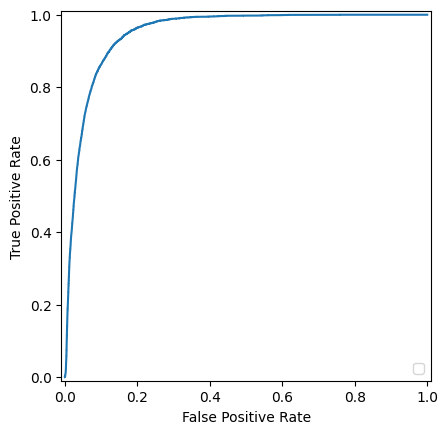

In [60]:
fpr, tpr, _ = sklearn.metrics.roc_curve(mask.ravel().int(), feature_distance.ravel())
roc_display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

En général, la détection de changements est nettement plus performante à l'aide des représentations apprises par des réseaux de neurones qu'en utilisant des descripteurs extraits des pixels. Cependant, tout n'est pas parfait ! En pratique, les détecteurs de changements commettent encore de nombreuses erreurs. Pour garantir que le détecteur a bien identifié *tous les changements*, il est nécessaire d'abaisser les seuils de détection, conduisant ainsi à une multiplication de faux positifs. Ces faux positifs devront ensuite être vérifiés manuellement par photo-interprétation, réduisant le gain de temps espéré par l'automatisation. La détection automatique de changements est un sujet de recherche encore ouvert, et notamment exploré au [LASTIG](https://www.umr-lastig.fr/), un des trois laboratoires associés à l'ENSG et l'IGN.

## Simuler des changements dans des images aériennes

Une des principales difficultés de la détection automatique des changements réside dans la faible disponibilité de données pour entraîner des modèles. En effet, les changements d'occupation des sols sont en pratique assez rares : seuls quelques pourcents du territoire  métropolitain changent chaque année. Annoter ces changements étant difficile, il n'existe pas de grande base de données qui permettrait d'apprendre des grands modèles profonds de détection de changements. Toutefois, une alternative existe : elle consiste à *simuler* des changements dans des images aériennes existantes.


Une option consiste par exemple à s'appuyer sur le [modèle Seg2Sat](https://github.com/RubenGres/Seg2Sat), développé par Ruben Gres, ingénieur IA à l'IGN. Seg2Sat est un réseau de neurones profond, dérivé de Stable Diffusion, permettant de générer des images aériennes semblables à celles de la BD ORTHO de l'IGN. Le modèle prend en entrée des cartes sémantiques détaillant l'occupation des sols de chaque pixel.

Nous allons voir les images que Seg2Sat est en mesure de générer et comment tirer parti du contrôle offert par les cartes sémantiques pour générer des images aériennes synthétiques dans les configurations souhaitées.

La démo se trouve ici : https://rubengr.es/Seg2Sat/

Essayez notamment de modifier seulement un peu les cartes sémantiques pour générer des variantes d'images aériennes. Par exemple, essayez d'ajouter ou de retirer des bâtiments dans l'image. Expérimentez différentes stratégies !

Cette approche a été adaptée avec succès pour entraîner des modèles de détection de changements par Yanis Benidir, doctorant au LASTIG ([article](https://yb23.github.io/projects/cywd/)).